In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA

import utils

### Load data (MNIST)

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0

X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


### Cluster input space

In [4]:
curr_digit = 0
eps = 3e-2

In [15]:
# Get labels for one-vs-all classification on curr_digit
one_v_all_trainloader, one_v_all_train_labels = utils.one_vs_all_dataloader(X_train, y_train, digit=curr_digit)

# Find RBF classification boundary in input space for curr_digit
input_cluster = SVC(kernel='rbf', C=1e-4, random_state=42, max_iter = 1e5, decision_function_shape='ovr').fit(X_train, one_v_all_train_labels)

In [16]:
# Test classification boundary found above
_, one_v_all_test_labels = utils.one_vs_all_dataloader(X_test, y_test, digit=curr_digit)

input_cluster.score(X_test, one_v_all_test_labels)

0.9837

### Train Model

Epoch 0 - Training loss: 0.336998910788121
Epoch 1 - Training loss: 0.13745228206512453
Epoch 2 - Training loss: 0.09455433837783489
Epoch 3 - Training loss: 0.06955293602973366
Epoch 4 - Training loss: 0.054784505962898564
Epoch 5 - Training loss: 0.04309100690963013
Epoch 6 - Training loss: 0.03587948580779858
Epoch 7 - Training loss: 0.026966541497618148
Epoch 8 - Training loss: 0.023033716806131393
Epoch 9 - Training loss: 0.0202002005003521
Epoch 10 - Training loss: 0.018331847477872826
Epoch 11 - Training loss: 0.014787683166281596
Epoch 12 - Training loss: 0.012487813556883439
Epoch 13 - Training loss: 0.012792191248787384
Epoch 14 - Training loss: 0.009873829394777696

Training Time (in minutes) = 0.2976260701815287
Predicted Digit = 6
Number Of Images Tested = 10000

Model Accuracy = 0.9777


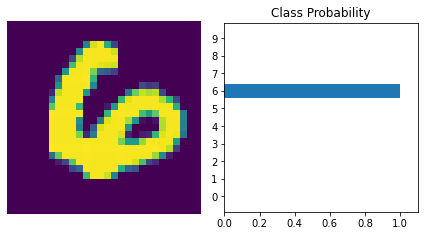

In [17]:
# Now let's start training the network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

model = utils.train_model(model, X_train, X_test, y_train, y_test, epochs=15)

### Get model outputs

In [18]:
one_v_all_trainloader, _ = utils.one_vs_all_dataloader(X_train, y_train, digit=curr_digit)

outputs = utils.get_network_outputs(model, one_v_all_trainloader)

### Cluster output space

In [20]:
# Percentage of samples flagged as suspicious 
# C=5e-2: adv: ~13.3%, clean: ~8%
# C=5e-3: adv: ~20.8%, clean: ~7.6%
# C=1.25e-3: adv: 32.9%, clean: 7.4%
# C=1e-3: adv: ~35.8%, clean: ~8%
# C=7.5e-4: adv: ~39.7%, clean: ~11%
# C=5e-4: adv: ~56.6%, clean: ~21.8%
output_cluster = SVC(kernel='rbf', C=1, random_state=42, max_iter = 1e5, decision_function_shape='ovr').fit(outputs, one_v_all_train_labels)

### Generate adversarial samples

In [21]:
one_v_all_testloader, _ = utils.one_vs_all_dataloader(X_test, y_test, digit=curr_digit)

adv_test_data = utils.add_adversarial_noise(model, one_v_all_testloader, eps=eps)

In [22]:
# Assess performance of input cluster classifier on adversarial data
input_cluster.score(adv_test_data, one_v_all_test_labels)

0.9677

In [23]:
# Assess performance of model on adversarial data
utils.eval_model(model, adv_test_data, y_test)

Number Of Samples Tested = 10000

Model Accuracy = 0.503


In [24]:
# Get model outputs on adversarial data
one_v_all_advloader, one_v_all_labels = utils.one_vs_all_dataloader(adv_test_data, y_test, digit=curr_digit)

adv_outputs = utils.get_network_outputs(model, one_v_all_advloader)

In [25]:
# Assess performance of output cluster classifier on model output of adversarial data
output_cluster.score(adv_outputs, one_v_all_test_labels)

0.5385

In [26]:
# Get input and output cluster predictions - if these disagree, we will consider the sample suspicious 
input_cluster_preds = input_cluster.predict(adv_test_data)
output_cluster_preds = output_cluster.predict(adv_outputs)

In [27]:
current_digit_idx = np.where(one_v_all_test_labels == 1)

In [28]:
# Proportion of adversarial data flagged as suspicious (in cluster in input but out of cluster in output)
(input_cluster_preds[current_digit_idx] != output_cluster_preds[current_digit_idx]).sum().item() / len(input_cluster_preds[current_digit_idx])

0.6035242290748899

In [29]:
# Proportion of clean data flagged as suspicious (in cluster in input but out of cluster in output)
clean_test_outputs = utils.get_network_outputs(model, one_v_all_testloader)

clean_in_cluster_preds = input_cluster.predict(X_test)
clean_out_cluster_preds = output_cluster.predict(clean_test_outputs)

(clean_in_cluster_preds[current_digit_idx] != clean_out_cluster_preds[current_digit_idx]).sum().item() / len(clean_in_cluster_preds[current_digit_idx])

0.007048458149779736